# Training and Saving the Violence-Detection model


---




## 1. Importing Libraries

In [0]:
import tensorflow as tf

In [0]:
#This section is for local GPU restrictions
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import  Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Creating Generators for training and validation data

In [0]:
train_path = '/home/aitik/cv/datasets/violence_dataset/Train'
valid_path = '/home/aitik/cv/datasets/violence_dataset/Valid'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['violent', 'non_violent'], batch_size=16)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['violent', 'non_violent'], batch_size=16)

Found 58921 images belonging to 2 classes.
Found 1411 images belonging to 2 classes.


## 3. Looking at a few examples

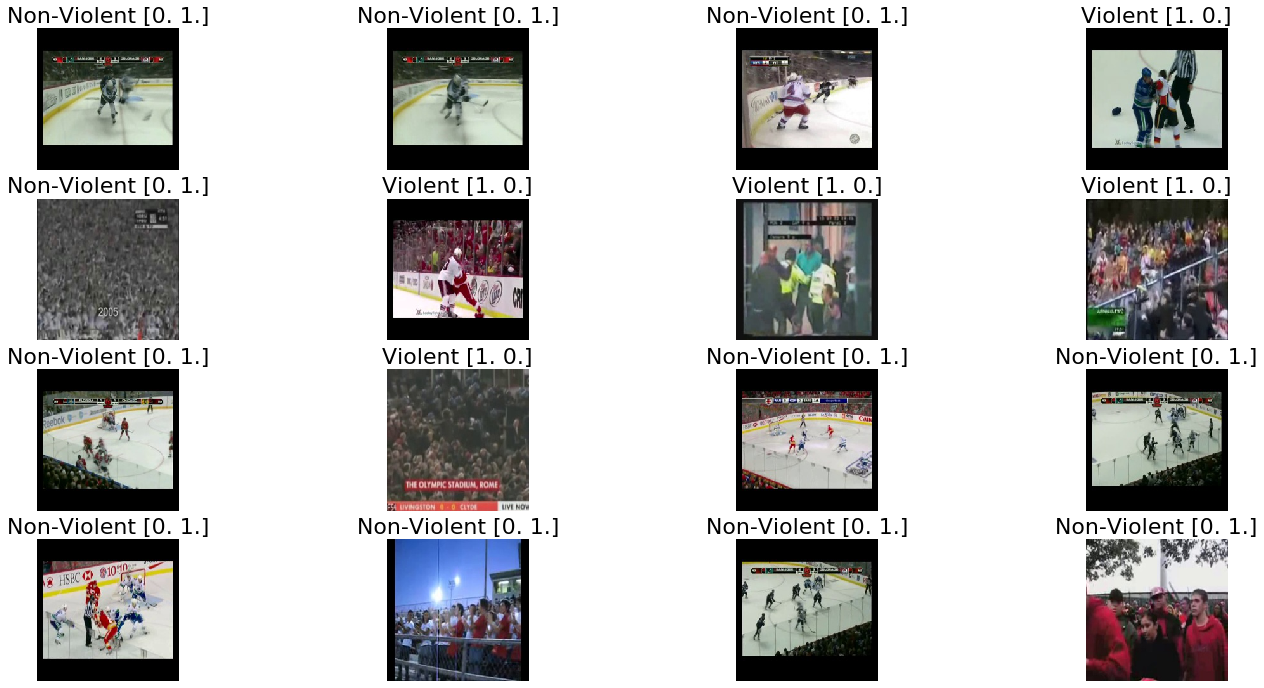

In [0]:
def plots(ims, figsize=(24,12), rows=4, interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
      ims = np.array(ims).astype(np.uint8)
      if (ims.shape[-1] != 3):
          ims = ims.transpose((0,2,3,1))
  f = plt.figure(figsize=figsize)
  cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
  for i in range(len(ims)):
      sp = f.add_subplot(rows, cols, i+1)
      sp.axis('Off')
      if titles is not None:
        if titles[i][0] == 1:
          sp.set_title("Violent "+str(titles[i]), fontsize=22)
        else:
          sp.set_title("Non-Violent "+str(titles[i]), fontsize=22)
      plt.imshow(ims[i], interpolation=None if interp else 'none')
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

## 4. Creating the model

In [0]:
#VGG-16 model without the top (Fully-Connected Layer)
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

#### Note: Last 4 layers are retrained

In [0]:
#Freezing all the VGG-16 model layers except last 4
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False

In [0]:
model = Sequential()
 
# Adding the vgg convolutional base model
model.add(vgg16_model)
 
# Adding new layers
model.add(tf.keras.layers.AveragePooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                294976    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,009,794
Trainable params: 7,374,530
Non-trainable params: 7,635,264
_________________________________________________________________


## 5. Training the model
(Note that this will take approximately 1-1.5 hours on GPU)

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_batches,
      steps_per_epoch=train_batches.samples/train_batches.batch_size ,
      epochs=3,
      validation_data=valid_batches,
      validation_steps=valid_batches.samples/valid_batches.batch_size,
      verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3682.5625 steps, validate for 88.1875 steps
Epoch 1/3
3683/3682 [==============================] - 1012s 275ms/step - loss: 0.0745 - acc: 0.9792 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2/3
3683/3682 [==============================] - 817s 222ms/step - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0503 - val_acc: 0.9880
Epoch 3/3
3683/3682 [==============================] - 652s 177ms/step - loss: 0.0024 - acc: 0.9991 - val_loss: 1.9081e-04 - val_acc: 1.0000


## 6. Looking at training and validation accuracy/loss vs epochs

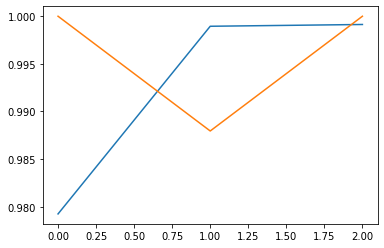

In [0]:
x1 = history.history['acc']
x2 = history.history['val_acc']
plt.plot(x1)
plt.plot(x2)

## 7. Saving the model

In [0]:
model.save('./model.h5')


---

Have a look at the Violence-Detection.ipynb file for testing the created model.

